<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 13: Redes neuronales, clasificacion </span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

# Clasificación con PyTorch

Este notebook está basado en las notas de **MRDBourke** y utiliza datos del famoso dataset del **[Titanic](https://www.kaggle.com/competitions/titanic/overview)** disponible en Kaggle.  
El objetivo es construir un modelo de **clasificación binaria** con **PyTorch**, que prediga la probabilidad de supervivencia de los pasajeros.

## Objetivo
Entrenar una red neuronal simple que aprenda a clasificar a los pasajeros del Titanic según las características disponibles, estimando si **sobrevivieron (1)** o **no sobrevivieron (0)**.

## Variables del dataset

| Variable | Descripción | Valores posibles |
|-----------|--------------|------------------|
| `survival` | Supervivencia | 0 = No, 1 = Sí |
| `pclass` | Clase del boleto | 1 = 1ª, 2 = 2ª, 3 = 3ª |
| `sex` | Sexo | — |
| `age` | Edad (en años) | — |
| `sibsp` | Nº de hermanos / cónyuges a bordo | — |
| `parch` | Nº de padres / hijos a bordo | — |
| `ticket` | Número de boleto | — |
| `fare` | Tarifa pagada | — |
| `cabin` | Número de cabina | — |
| `embarked` | Puerto de embarque | C = Cherbourg, Q = Queenstown, S = Southampton |

---

A lo largo del notebook se realizará el **preprocesamiento de datos**, la **construcción del modelo**, y la **evaluación de su desempeño** mediante métricas de clasificación como **exactitud** y **matriz de confusión**.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn

%matplotlib inline

In [2]:
df_titanic_train = pd.read_csv("titanic_data/train.csv")
df_titanic_test = pd.read_csv("titanic_data/test.csv")

# Algunas variables no son necesarias

variables = ['Pclass','Sex', 'Age', 'SibSp','Parch', 'Fare', 'Cabin', 'Embarked','Survived']
variables_2 = variables.copy()
variables_2.remove('Survived')

df_titanic_train = df_titanic_train[variables]
df_titanic_test = df_titanic_test[variables_2]


print(df_titanic_train.head(5))

print('Shape(Train)',df_titanic_train.shape)
print('Shape(test)',df_titanic_test.shape)

   Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked  Survived
0       3    male  22.0      1      0   7.2500   NaN        S         0
1       1  female  38.0      1      0  71.2833   C85        C         1
2       3  female  26.0      0      0   7.9250   NaN        S         1
3       1  female  35.0      1      0  53.1000  C123        S         1
4       3    male  35.0      0      0   8.0500   NaN        S         0
Shape(Train) (891, 9)
Shape(test) (418, 8)


In [3]:
df_titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Cabin     204 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


In [4]:
# Valores nulos
df_titanic_train.isna().sum().to_frame().head(83)

,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Cabin,687
Embarked,2
Survived,0


In [5]:
# Valores nulos
df_titanic_test.isna().sum().to_frame().head(83)

,0
Pclass,0
Sex,0
Age,86
SibSp,0
Parch,0
Fare,1
Cabin,327
Embarked,0


Podemos ignorar la variable Cabin. Para la variable de edad, (... podríamos rellenarlo con la media .... o no).

In [6]:
columns = ['Pclass','Sex', 'Age', 'SibSp','Parch', 'Fare', 'Embarked','Survived']
columns_2 = columns.copy()
columns_2.remove('Survived')

df2_titanic_train = df_titanic_train.copy()
df2_titanic_test = df_titanic_test.copy()

df2_titanic_train = df2_titanic_train[columns]
df2_titanic_test = df2_titanic_test[columns_2]

df2_titanic_train['Age'] = df2_titanic_train['Age'].fillna(df2_titanic_train['Age'].mean())
df2_titanic_test['Age'] = df2_titanic_test['Age'].fillna(df2_titanic_test['Age'].mean())

In [7]:
# Variables categoricas y numéricas

categorical = df2_titanic_train.select_dtypes(include=['object']).columns.tolist()
numerical = df2_titanic_train.select_dtypes(include='number').columns.tolist()

In [8]:
# Variables dummy con pandas

df3_titanic_train = df2_titanic_train.copy()
df3_titanic_test = df2_titanic_test.copy()


for element in categorical:
    tab_dummy = pd.get_dummies(df3_titanic_train[element],prefix=element, dtype=int)
    data_new = df3_titanic_train.join(tab_dummy)
    df3_titanic_train = data_new
    
for element in categorical:
    tab_dummy = pd.get_dummies(df3_titanic_test[element],prefix=element, dtype=int)
    data_new = df3_titanic_test.join(tab_dummy)
    df3_titanic_test = data_new

# Quitamos las columnas redundantes
to_keep = [element for element in df3_titanic_train.columns if element not in categorical]
to_keep_2 = [element for element in df3_titanic_test.columns if element not in categorical]

df3_titanic_train = df3_titanic_train[to_keep]
df3_titanic_test = df3_titanic_test[to_keep_2]

In [9]:
df3_titanic_train

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,1,0,1,0,0
2,3,26.000000,0,0,7.9250,1,1,0,0,0,1
3,1,35.000000,1,0,53.1000,1,1,0,0,0,1
4,3,35.000000,0,0,8.0500,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,0,1,0,0,1
887,1,19.000000,0,0,30.0000,1,1,0,0,0,1
888,3,29.699118,1,2,23.4500,0,1,0,0,0,1
889,1,26.000000,0,0,30.0000,1,0,1,1,0,0


In [12]:
# Features y class
X_list = to_keep.copy()
X_list.remove('Survived')
Y_list = 'Survived'

In [16]:
# Dataframes a array

X_df = df3_titanic_train[X_list]
Y_df = df3_titanic_train[Y_list]

In [17]:
X_df_train, X_df_test, Y_df_train, Y_df_test = train_test_split(X_df,
                                                                Y_df,
                                                                test_size=0.2,
                                                                random_state=42)

In [19]:
X_array_train = X_df_train.to_numpy()
X_array_test = X_df_test.to_numpy()
Y_array_train = Y_df_train.to_numpy()
Y_array_test = Y_df_test.to_numpy()

In [20]:
X_array_train

array([[ 1. , 45.5,  0. , ...,  0. ,  0. ,  1. ],
       [ 2. , 23. ,  0. , ...,  0. ,  0. ,  1. ],
       [ 3. , 32. ,  0. , ...,  0. ,  0. ,  1. ],
       ...,
       [ 3. , 41. ,  2. , ...,  0. ,  0. ,  1. ],
       [ 1. , 14. ,  1. , ...,  0. ,  0. ,  1. ],
       [ 1. , 21. ,  0. , ...,  0. ,  0. ,  1. ]])

## Arquitectura de una red neuronal para clasificación

| Hiperparámetro | Clasificación binaria | Clasificación multiclase |
| --- | --- | --- |
| Capa de entrada | El mismo que el número de variables de entrada | Igual que clasificación binaria|
| Capas ocultas | Depende del problema. Teóricamente puede ir de 1 a infinito | Igual que clasificación binaria|
| Neuronas por capa oculta | Depende del probleme. Usualmente entre 10 y 512 | Igual que clasificación binaria|
| Capas de salida | 1 (una por clase) | Una por cada clase|
| Función de activación de capas ocultas | Típica: ReLU, pero puede ser cualquiera. | Igual que clasificación binaria|
| Función de activación de capa de salida | Típica: Sigmoid | [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) |
| Loss Function | [Binary crossentropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) | [Crossentropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)|
| Optimizador | SGD, [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) | Igual que clasificación binaria|

## Arrays a tensores, y sets de entrenamiento y validación

In [21]:
X_train = torch.from_numpy(X_array_train).type(torch.float)
X_test = torch.from_numpy(X_array_test).type(torch.float)
y_train = torch.from_numpy(Y_array_train).type(torch.float)
y_test = torch.from_numpy(Y_array_test).type(torch.float)

## Creando el modelo

Ya tenemos nuestros datos listos, así que es momento de **construir un modelo** de clasificación utilizando **PyTorch**.  
El proceso lo dividiremos en varios pasos clave:

1. Configurar código **agnóstico al dispositivo** (CPU o GPU).  
2. Construir un modelo **subclasificando `nn.Module`**.  
3. Definir una **función de pérdida** y un **optimizador**.  
4. Crear un **bucle de entrenamiento**.

La buena noticia es que ya hemos seguido estos pasos antes (en el notebook anterior), solo que ahora los **ajustaremos para un problema de clasificación**.

---

## Configuración del dispositivo

Comenzamos importando las librerías necesarias y preparando el entorno para que el modelo pueda ejecutarse en **CPU o GPU**, según disponibilidad. Si tu equipo tiene acceso a una GPU compatible, pytorch la utilizará automáticamente. Esto permite que todo --datos, modelos y tensores -- se gestionesn en el dispositivo adecuado.

In [25]:
torch.cuda.is_available()

False

In [27]:
torch.backends.mps.is_available()

True

In [28]:
# Fijar el tipo de hardware
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [30]:
# Shapes de tensores

X_train.shape

torch.Size([712, 10])

## Creación del modelo

Queremos un modelo que reciba nuestros datos de entrada `X`(features) y produzca una predicción `y`, es decir, un tipo de problema supervisado. Para ello, definiremos una clase en python que,

* Herede de `nn.module` (como todos los modelos de pytorch)
* Cree dos capas lineales `nn.linear` en el constructor, con las dimensiones de entrada y salida adecuadas para nuestros datos.
* Implemente un método `forward()` que defina la propagación hacia adelante del modelo
* Instanciamos el modelo y lo envíamos al dispositivo configurado

In [31]:
# 1. Construimos la clase del modelo con la subclase nn.Module
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Creamos las capas de entrada (lineales) capaces de manejar los features de entrada y clase de salida
        self.layer_1 = nn.Linear(in_features=10, out_features=20) # toma 10 features (X), produce 20 features
        self.layer_2 = nn.Linear(in_features=20, out_features=1) # toma 20 features, produce 1 feature (y)
    
    # 3. Definimos un método para la propagación (forward)
    def forward(self, x):
        # Regresa la capa de salida de layer_2, un solo features, con el mismo shape que y
        # El calculo pasa sobre layer_1 y luego su output es el input de layer_2
        return self.layer_2(self.layer_1(x)) 

# 4. Creamos una instancia con el modelo y se manda al hardware
model_0 = ModelV0().to(device)
model_0

ModelV0(
  (layer_1): Linear(in_features=10, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=1, bias=True)
)

La primera capa (`layer_1`) recibe 2 características de entrada (`in_features=2`) y produce 5 salidas (`out_features=5`). Estas 5 salidas se conocen como unidades ocultas, y permiten al modelo aprender **patrones más complejos**.

La segunda capa (`layer_2`) toma esas 5 características y las transforma en una única salida (`out_features=1`), que corresponden a la predicción del modelo.

**NOTA**: El número de unidades ocultas las elige uno. Más unidades podrían capturar patrones más complejos, pero también pueden provocar sobreajuste y entrenamiento más lento.

## `nn.Sequential`

El método `nn.Sequential()` ejecuta la propagación hacia adelante en el orden en que aparecen las capas, simplificando la sintaxis cuando no se requieren pasos intermedios personalizados.

In [66]:
# Se replica el modelV0
model_0 = nn.Sequential(
    nn.Linear(in_features=10, out_features=20),
    nn.Linear(in_features=20, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=10, out_features=20, bias=True)
  (1): Linear(in_features=20, out_features=1, bias=True)
)

In [67]:
# Hacemos predicciones con el modelo
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 179, Shape: torch.Size([179, 1])
Length of test samples: 179, Shape: torch.Size([179])

First 10 predictions:
tensor([[1.3630],
        [1.5595],
        [1.0445],
        [0.4934],
        [0.7088],
        [1.5590],
        [1.5053],
        [0.7810],
        [0.8900],
        [1.0415]], device='mps:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1.], device='mps:0')


## Configuración de la función de pérdida y el optimizador

Ya hemos configurado modelos, así que ahora toca definir **cómo aprenderá**, a través de una **función de pérdida** (*loss function*) y un **optimizador**.

En el notebook previo ya usamos estos conceptos, pero es importante notar que **diferentes tipos de problemas requieren distintas funciones de pérdida.**

---

## Función de pérdida

La función de pérdida (también llamada *cost function*) mide **qué tan equivocadas son las predicciones del modelo**. Mientras más alto sea su valor, peor está aprendiendo el modelo.  El entrenamiento consiste en **minimizar esta pérdida**.

Ejemplos comunes:

| Función / Optimizador | Tipo de problema | Código en PyTorch |
|------------------------|------------------|-------------------|
| Stochastic Gradient Descent (SGD) | Clasificación, regresión, muchos otros | `torch.optim.SGD()` |
| Adam Optimizer | Clasificación, regresión, muchos otros | `torch.optim.Adam()` |
| Binary Cross Entropy (BCE) | Clasificación binaria | `torch.nn.BCELoss()` o `torch.nn.BCEWithLogitsLoss()` |
| Cross Entropy | Clasificación multiclase | `torch.nn.CrossEntropyLoss()` |
| Mean Absolute Error (MAE) / L1 Loss | Regresión | `torch.nn.L1Loss()` |
| Mean Squared Error (MSE) / L2 Loss | Regresión | `torch.nn.MSELoss()` |

---

## Elección para nuestro caso

Como estamos trabajando con un **problema de clasificación binaria**, la opción más adecuada es usar una **pérdida de entropía cruzada binaria** (*binary cross entropy loss*).

PyTorch ofrece dos versiones:

- `torch.nn.BCELoss()`  
  Calcula la entropía cruzada binaria entre las predicciones y las etiquetas.
  
- `torch.nn.BCEWithLogitsLoss()`  
  Hace lo mismo, pero **integra internamente una función sigmoide** (`nn.Sigmoid`).  
  Esto la hace **más estable numéricamente** y generalmente se recomienda sobre la anterior.

> 💡 **Recomendación:**  
> Usa `torch.nn.BCEWithLogitsLoss()` en la mayoría de los casos de clasificación binaria.  
> Evita aplicar manualmente un `Sigmoid` si utilizas esta versión.

---

## Optimizador

El optimizador es el algoritmo que **ajusta los pesos del modelo** para minimizar la pérdida.  Podemos usar el clásico **descenso de gradiente estocástico (SGD)** o el más moderno **Adam**. Ambos funcionan bien, pero empezaremos con **SGD** para mayor claridad.


In [68]:
# Loss Function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Optimizador
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.01)

In [69]:
# Métrica de evaluación (accuracy)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calcula si dos tensores son iguales
    acc = (correct / len(y_pred)) * 100 
    return acc


## Entrenamiento del modelo

Antes de realizar el loop de entrenamiento, veamos que sale del modelo al realizar una propagación hacia adelante, usando los datos de validacion.

In [70]:
# Los 5 primeros outputs
y_logits = model_0(X_test.to(device))[:5]
y_logits


tensor([[1.3630],
        [1.5595],
        [1.0445],
        [0.4934],
        [0.7088]], device='mps:0', grad_fn=<SliceBackward0>)

Como el modelo todavía **no ha sido entrenado**, sus salidas son esencialmente **valores aleatorios**.  Durante la **propagación hacia adelante**, los datos pasan a través de las dos capas lineales definidas, las cuales aplican internamente la siguiente ecuación:

\begin{equation}
y = x \cdot w^T + \mathrm{bias}
\end{equation}

Los valores resultantes $y$ de esta operación, así como los que produce el modelo, se conocen como **_logits_**.  En un modelo puramente lineal, estos logits representarían simplemente **valores numéricos** sin restricción en su rango (pueden ser negativos o positivos).

Si aplicamos una **función de activación sigmoide** sobre ellos, podemos convertir dichos valores en **probabilidades** dentro del intervalo $(0, 1)$, lo que nos permite interpretar el resultado como:

\begin{equation}
\text{probabilidad de clase positiva} = \sigma(y) = \frac{1}{1 + e^{-y}}
\end{equation}

De este modo, al establecer un **umbral (threshold)** —por ejemplo, 0.5— podemos transformar las probabilidades en una **clasificación binaria**:

- Si $\sigma(y) \ge 0.5$ → clase **1 (positivo)**  
- Si $\sigma(y) < 0.5$ → clase **0 (negativo)**

> 💡 **Nota:** En PyTorch, cuando se utiliza `nn.BCEWithLogitsLoss`, la función sigmoide ya está incorporada dentro de la función de pérdida, por lo que **no es necesario aplicarla manualmente** en la salida del modelo.


In [71]:
# Sigmoid
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.7963],
        [0.8263],
        [0.7397],
        [0.6209],
        [0.6701]], device='mps:0', grad_fn=<SigmoidBackward0>)

In [72]:
# Redondeamos para obtener una clasificación (threshold 0.5)
#y_preds = torch.round(y_pred_probs)
threshold = 0.5
y_preds = (y_pred_probs >= threshold).float()

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Checamos igualdad
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Quitamos la dimensión extra
y_preds.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 1., 1., 1., 1.], device='mps:0')

In [73]:
y_test[:5]
# Vemos que ahora si tenemos las etiquetas que queremos

tensor([1., 0., 0., 1., 1.], device='mps:0')

In [74]:
torch.manual_seed(88) # semilla aleatoria

# Número de epocas
epochs = 1000

# Poner los datos en el hardware target
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_loss_list = []
test_loss_list = []

# Loop de training y eval
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward propagation (el modelo regresa logits)
    y_logits = model_0(X_train).squeeze() # squeeze para remover `1` dimension extra
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labls
  
    # 2. Se calcula loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss acepta los logits de salida
                   y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Zero grad para el optimizador
    optimizer.zero_grad()

    # 4. Back propagation
    loss.backward()

    # 5. Optimizador
    optimizer.step()

    ### Evaluacion
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward 
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print cada 10 epocas
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        train_loss_list.append(loss)
        test_loss_list.append(test_loss)

Epoch: 0 | Loss: 1.16306, Accuracy: 37.78% | Test loss: 2.00418, Test acc: 58.66%
Epoch: 10 | Loss: 1.53208, Accuracy: 43.40% | Test loss: 0.73070, Test acc: 65.36%
Epoch: 20 | Loss: 0.77356, Accuracy: 64.47% | Test loss: 0.90248, Test acc: 58.66%
Epoch: 30 | Loss: 0.64264, Accuracy: 68.12% | Test loss: 0.64960, Test acc: 62.57%
Epoch: 40 | Loss: 1.02167, Accuracy: 61.52% | Test loss: 0.64553, Test acc: 64.80%
Epoch: 50 | Loss: 0.71083, Accuracy: 66.85% | Test loss: 0.71363, Test acc: 58.66%
Epoch: 60 | Loss: 0.68624, Accuracy: 67.98% | Test loss: 0.67134, Test acc: 59.78%
Epoch: 70 | Loss: 0.69462, Accuracy: 68.12% | Test loss: 0.65710, Test acc: 59.22%
Epoch: 80 | Loss: 0.67428, Accuracy: 67.98% | Test loss: 0.64648, Test acc: 59.22%
Epoch: 90 | Loss: 0.65893, Accuracy: 67.84% | Test loss: 0.63801, Test acc: 59.78%
Epoch: 100 | Loss: 0.64717, Accuracy: 68.12% | Test loss: 0.63110, Test acc: 60.89%
Epoch: 110 | Loss: 0.63801, Accuracy: 68.54% | Test loss: 0.62537, Test acc: 61.45%
Epo

In [75]:
train_loss_list_cpu = torch.Tensor(train_loss_list).cpu().detach().numpy()
train_loss_list_cpu

array([1.163063  , 1.5320771 , 0.7735554 , 0.6426399 , 1.0216701 ,
       0.7108254 , 0.6862402 , 0.69462234, 0.67428136, 0.65892565,
       0.6471669 , 0.638014  , 0.6307739 , 0.624958  , 0.62021875,
       0.6163052 , 0.6130331 , 0.61026603, 0.60790056, 0.6058575 ,
       0.60407543, 0.6025059 , 0.6011107 , 0.5998588 , 0.59872586,
       0.5976911 , 0.5967386 , 0.5958549 , 0.59502894, 0.59425163,
       0.5935157 , 0.5928149 , 0.59214425, 0.5914993 , 0.59087706,
       0.59027416, 0.58968836, 0.58911777, 0.5885606 , 0.5880154 ,
       0.5874809 , 0.58695614, 0.5864405 , 0.58593297, 0.585433  ,
       0.58493984, 0.5844534 , 0.58397293, 0.58349806, 0.58302855,
       0.58256406, 0.58210427, 0.58164907, 0.58119804, 0.5807511 ,
       0.580308  , 0.57986844, 0.57943255, 0.5789999 , 0.5785703 ,
       0.5781439 , 0.5777204 , 0.5772996 , 0.5768816 , 0.57646614,
       0.5760531 , 0.57564247, 0.5752344 , 0.57482845, 0.57442456,
       0.5740229 , 0.5736235 , 0.5732258 , 0.5728303 , 0.57243

In [76]:
test_loss_list_cpu = torch.Tensor(test_loss_list).cpu().detach().numpy()
test_loss_list_cpu

array([2.0041788 , 0.7307008 , 0.9024806 , 0.6495987 , 0.64553213,
       0.7136336 , 0.67134345, 0.6571004 , 0.6464777 , 0.63801265,
       0.63110256, 0.62536746, 0.6205414 , 0.6164325 , 0.6128982 ,
       0.6098295 , 0.60714114, 0.6047655 , 0.6026471 , 0.60074157,
       0.5990119 , 0.5974278 , 0.5959644 , 0.5946011 , 0.59332126,
       0.59211075, 0.59095854, 0.5898555 , 0.5887939 , 0.58776766,
       0.5867718 , 0.58580226, 0.58485574, 0.58392936, 0.58302116,
       0.5821292 , 0.5812519 , 0.58038825, 0.57953703, 0.5786977 ,
       0.57786924, 0.5770513 , 0.5762434 , 0.57544506, 0.574656  ,
       0.57387596, 0.57310456, 0.5723418 , 0.57158726, 0.57084095,
       0.5701026 , 0.5693722 , 0.5686494 , 0.56793433, 0.56722665,
       0.56652635, 0.56583333, 0.5651475 , 0.56446886, 0.563797  ,
       0.56313205, 0.56247395, 0.5618224 , 0.56117743, 0.5605391 ,
       0.5599071 , 0.55928123, 0.55866176, 0.55804837, 0.5574408 ,
       0.5568393 , 0.5562436 , 0.5556537 , 0.5550694 , 0.55449

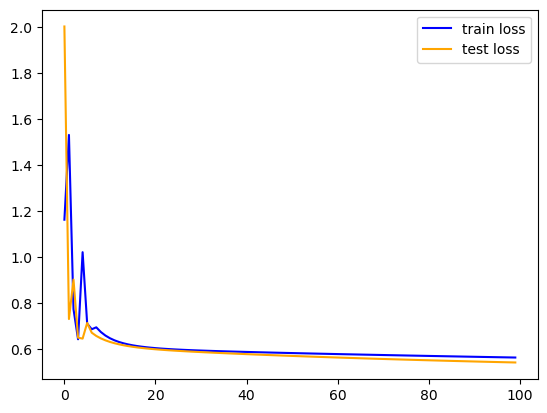

In [78]:
x_array = np.arange(0,100,1)
plt.plot(x_array, train_loss_list_cpu, color='blue', label="train loss")
plt.plot(x_array, test_loss_list_cpu, color='orange', label="test loss")
plt.legend()
plt.show()

## Mejorando el modelo

Una vez que el modelo básico está funcionando, existen diversas estrategias para **mejorar su desempeño**.  Cada una de las siguientes técnicas busca aumentar la capacidad del modelo para **aprender patrones más complejos** o **ajustarse mejor a los datos**.

---

### 1. Añadir más capas
Cada capa adicional puede incrementar la **capacidad de representación** del modelo, permitiéndole aprender **patrones más abstractos y no lineales**. Agregar más capas hace que la red sea más **profunda**, lo que da origen al término *deep learning*.

---

### 2. Añadir más neuronas ocultas
De forma similar, aumentar el número de **neuronas (unidades ocultas)** dentro de una capa puede mejorar la capacidad del modelo para capturar relaciones complejas entre las variables. Sin embargo, demasiadas neuronas pueden llevar al **sobreajuste (overfitting)**.

---

### 3. Entrenar por más épocas
Dar al modelo más **épocas** (iteraciones completas sobre los datos) permite que los pesos se actualicen más veces, lo que puede mejorar el rendimiento si el modelo aún no ha convergido. Pero un número excesivo de épocas también puede causar **sobreajuste**.

---

### 4. Cambiar la función de activación
Los datos reales rara vez son lineales. Usar funciones de activación **no lineales** (como ReLU, tanh o sigmoid) permite que el modelo aprenda relaciones más complejas.  
Por ejemplo:
- `nn.ReLU()` → común en redes profundas.  
- `nn.Sigmoid()` → útil en clasificación binaria.  
- `nn.Tanh()` → centrada en 0, útil para ciertos tipos de datos.

---

### 5. Ajustar la tasa de aprendizaje
La **tasa de aprendizaje** (`learning_rate`) controla qué tanto se ajustan los parámetros en cada actualización.  
- Si es **demasiado alta**, el modelo puede **oscilar o divergir**.  
- Si es **demasiado baja**, el aprendizaje será **muy lento** o se quedará estancado en un mínimo local.  

Encontrar un valor adecuado requiere **experimentación o búsqueda sistemática (grid/random search)**.

---

### 6. Cambiar la función de pérdida
Cada tipo de problema (clasificación binaria, multiclase, regresión, etc.) requiere una **función de pérdida diferente**.  
Probar distintas opciones puede mejorar la estabilidad o precisión del aprendizaje.

Ejemplo:
- Clasificación binaria → `nn.BCEWithLogitsLoss()`
- Clasificación multiclase → `nn.CrossEntropyLoss()`
- Regresión → `nn.MSELoss()` o `nn.L1Loss()`

---

### 7. Transfer learning
En lugar de entrenar un modelo desde cero, se puede **aprovechar un modelo preentrenado** en un problema similar y **ajustarlo (fine-tuning)** a los nuevos datos.  
Esta técnica es muy útil cuando se dispone de **pocos datos** o se trabaja con **dominios complejos**, como imágenes o texto.

---

> **NOTA:** No existe una receta única para mejorar el modelo.  
> La práctica más común es **ajustar un hiperparámetro a la vez**, observar su impacto en la pérdida y en las métricas de validación, y repetir el proceso hasta encontrar un equilibrio entre **precisión y generalización**.


In [79]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=10, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20) # capa extra
        self.layer_3 = nn.Linear(in_features=20, out_features=1)
        
    def forward(self, x): 
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = ModelV1().to(device)
model_1


ModelV1(
  (layer_1): Linear(in_features=10, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
)

In [80]:
loss_fn = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [84]:
torch.manual_seed(88) # semilla aleatoria

# Número de epocas
epochs = 1500

# Poner los datos en el hardware target
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop de training y eval
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward propagation (el modelo regresa logits)
    y_logits = model_1(X_train).squeeze() # squeeze para remover `1` dimension extra
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labls
  
    # 2. Se calcula loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss acepta los logits de salida
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Zero grad para el optimizador
    optimizer.zero_grad()

    # 4. Back propagation
    loss.backward()

    # 5. Optimizador
    optimizer.step()

    ### Evaluacion
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward 
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print cada 10 epocas
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.48872, Accuracy: 80.06% | Test loss: 0.47162, Test acc: 77.09%
Epoch: 10 | Loss: 0.48860, Accuracy: 80.06% | Test loss: 0.47149, Test acc: 77.09%
Epoch: 20 | Loss: 0.48848, Accuracy: 80.06% | Test loss: 0.47137, Test acc: 77.09%
Epoch: 30 | Loss: 0.48836, Accuracy: 80.06% | Test loss: 0.47124, Test acc: 76.54%
Epoch: 40 | Loss: 0.48825, Accuracy: 80.06% | Test loss: 0.47111, Test acc: 76.54%
Epoch: 50 | Loss: 0.48813, Accuracy: 80.06% | Test loss: 0.47098, Test acc: 76.54%
Epoch: 60 | Loss: 0.48801, Accuracy: 80.06% | Test loss: 0.47086, Test acc: 76.54%
Epoch: 70 | Loss: 0.48789, Accuracy: 80.06% | Test loss: 0.47073, Test acc: 76.54%
Epoch: 80 | Loss: 0.48778, Accuracy: 80.06% | Test loss: 0.47061, Test acc: 76.54%
Epoch: 90 | Loss: 0.48766, Accuracy: 80.06% | Test loss: 0.47048, Test acc: 77.09%
Epoch: 100 | Loss: 0.48755, Accuracy: 80.06% | Test loss: 0.47036, Test acc: 77.09%
Epoch: 110 | Loss: 0.48743, Accuracy: 80.20% | Test loss: 0.47023, Test acc: 77.09%
Epo

In [85]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=10, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20)
        self.layer_3 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU() # <- Se añade función de activación ReLU
        # También se puede usar sigmoid, pero se tendría que quitar en la parte de transformación del output 
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # ReLU se aplica entre capas
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = ModelV2().to(device)
print(model_3)

ModelV2(
  (layer_1): Linear(in_features=10, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


In [86]:
torch.manual_seed(88) # semilla aleatoria

# Número de epocas
epochs = 3500

# Poner los datos en el hardware target
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop de training y eval
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward propagation (el modelo regresa logits)
    y_logits = model_1(X_train).squeeze() # squeeze para remover `1` dimension extra
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labls
  
    # 2. Se calcula loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss acepta los logits de salida
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Zero grad para el optimizador
    optimizer.zero_grad()

    # 4. Back propagation
    loss.backward()

    # 5. Optimizador
    optimizer.step()

    ### Evaluacion
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward 
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print cada 10 epocas
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.47559, Accuracy: 81.32% | Test loss: 0.45694, Test acc: 78.21%
Epoch: 10 | Loss: 0.47553, Accuracy: 81.32% | Test loss: 0.45687, Test acc: 78.21%
Epoch: 20 | Loss: 0.47546, Accuracy: 81.32% | Test loss: 0.45680, Test acc: 78.21%
Epoch: 30 | Loss: 0.47540, Accuracy: 81.32% | Test loss: 0.45673, Test acc: 78.21%
Epoch: 40 | Loss: 0.47534, Accuracy: 81.32% | Test loss: 0.45665, Test acc: 78.21%
Epoch: 50 | Loss: 0.47528, Accuracy: 81.32% | Test loss: 0.45658, Test acc: 78.21%
Epoch: 60 | Loss: 0.47522, Accuracy: 81.32% | Test loss: 0.45651, Test acc: 78.21%
Epoch: 70 | Loss: 0.47516, Accuracy: 81.32% | Test loss: 0.45644, Test acc: 78.21%
Epoch: 80 | Loss: 0.47509, Accuracy: 81.32% | Test loss: 0.45637, Test acc: 78.21%
Epoch: 90 | Loss: 0.47503, Accuracy: 81.32% | Test loss: 0.45630, Test acc: 78.21%
Epoch: 100 | Loss: 0.47497, Accuracy: 81.32% | Test loss: 0.45623, Test acc: 78.21%
Epoch: 110 | Loss: 0.47491, Accuracy: 81.32% | Test loss: 0.45616, Test acc: 78.21%
Epo